In [ ]:
!wget "https://cdn.rcsb.org/etl/kabschSander/ss.txt.gz"

--2019-06-29 07:16:29--  https://cdn.rcsb.org/etl/kabschSander/ss.txt.gz
Resolving cdn.rcsb.org (cdn.rcsb.org)... 132.249.213.72
Connecting to cdn.rcsb.org (cdn.rcsb.org)|132.249.213.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41294075 (39M) [application/x-gzip]
Saving to: ‘ss.txt.gz’

ss.txt.gz           100%[===================>]  39.38M   485KB/s    in 94s     

2019-06-29 07:18:03 (429 KB/s) - ‘ss.txt.gz’ saved [41294075/41294075]



In [ ]:
!gunzip ss.txt.gz

In [ ]:
import gzip
import logging
import csv
import argparse

with open('ss.txt', 'rt') as inf:
    # cannot use SeqIO.parse from Biopython because it cannot handle empty
    # string in DSSP secondary structure properly! Just put here for
    # reference

    # e.g. seqio = SeqIO.parse(inf, format='fasta')

    with open('out.csv', 'wt') as opf:
        csv_writer = csv.writer(opf)
        csv_writer.writerow(['pdb_id', 'chain_code', 'seq', 'sst'])

        state = None
        count = 0
        seq_id, seq_chain_id = '', ''
        sst_id, sst_chain_id = '', ''
        seq, sst = '', ''
        log_interval = 30000
        for k, line in enumerate(inf):
            if line.startswith('>'):
                line = line.replace('>', '')
                if state is None or state == 'ss':
                    if state == 'ss':
                        assert seq_id == sst_id
                        assert seq_chain_id == sst_chain_id
                        csv_writer.writerow(
                            [seq_id, seq_chain_id, seq, sst]
                        )
                        count += 1
                        if count % log_interval == 0:
                            msg = 'processing {0}th record'.format(count)
                            logging.info(msg)

                    state = 'seq'
                    seq_id = line.split(':')[0]
                    seq_chain_id = line.split(':')[1]
                    seq, sst = '', ''
                elif state == 'seq':
                    state = 'ss'
                    sst_id = line.split(':')[0]
                    sst_chain_id = line.split(':')[1]
                else:
                    raise ValueError('unknown state: {0}'.format(state))
                continue

            if state == 'seq':
                seq += line.strip()
            else:
                sst += line.replace(' ', 'C').strip()

        # count last seq
        count += 1

In [ ]:
import pandas as pd
data = pd.read_csv("out.csv")
data.head()

,pdb_id,chain_code,seq,sst
0,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...
1,102L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,CCHHHHHHHHHCCEEEEEECTTSCEEEETTEEEESSSCTTTHHHHH...
2,102M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...
3,103L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,CCHHHHHHHHHCCEEEEEECTTSCEEEETTEECCCCCCCCCHHHHH...
4,103M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...


In [ ]:
import datetime
import itertools
import pandas as pd

STATE_DD_8T3 = {
    'G': 'H',
    'H': 'H',
    'I': 'H',
    
    'B': 'E',
    'E': 'E',
    
    'T': 'C',
    'S': 'C',
    'C': 'C',
}

In [ ]:
STANDARD_AAS = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
NON_STANDARD_AAS = list('BJOUXZ')

def mask_unk_aa(seq):
    for i in NON_STANDARD_AAS:
        seq = seq.replace(i, '*')
    return seq
  
def convert_8t3_state(sst):
    out = sst
    for i, j in STATE_DD_8T3.items():
        out = out.replace(i, j)
    return out
  

In [ ]:
adf = pd.read_csv('out.csv')
%time all_chars = set(itertools.chain(*adf.seq.values))
all_chars - set(STANDARD_AAS)
set(STANDARD_AAS) - all_chars
%time adf['seq'] = adf.seq.apply(mask_unk_aa).to_frame()
assert set(itertools.chain(*adf.seq.values)) - set(STANDARD_AAS) == set(['*'])
adf.rename(columns={'sst': 'sst8'}, inplace=True)

CPU times: user 2.14 s, sys: 540 µs, total: 2.14 s
Wall time: 2.14 s
CPU times: user 647 ms, sys: 4.77 ms, total: 652 ms
Wall time: 651 ms


In [ ]:
%time adf['sst3'] = adf['sst8'].apply(convert_8t3_state)
%time adf['len'] = adf.seq.apply(lambda s: len(s))
adf.head(1).T
adf.sort_values(['len', 'pdb_id', 'chain_code'], inplace=True)
%time adf['has_nonstd_aa'] = adf.seq.apply(lambda s: '*' in s)
adf.head()

CPU times: user 1.49 s, sys: 90 ms, total: 1.58 s
Wall time: 1.58 s
CPU times: user 183 ms, sys: 7.93 ms, total: 191 ms
Wall time: 191 ms
CPU times: user 110 ms, sys: 0 ns, total: 110 ms
Wall time: 111 ms


,pdb_id,chain_code,seq,sst8,sst3,len,has_nonstd_aa
377,1A30,C,EDL,CBC,CEC,3,False
2336,1B05,B,KCK,CBC,CEC,3,False
2369,1B0H,B,KAK,CBC,CEC,3,False
2419,1B1H,B,KFK,CBC,CEC,3,False
2473,1B2H,B,KAK,CBC,CEC,3,False


(433099, 7)
95891


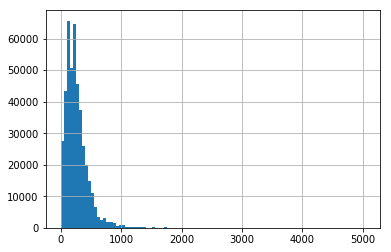

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = adf
df.len.hist(bins=100)
print(df.shape)

def seq2ngrams(seqs, n=3):
    return np.array([[seq[i:i+n] for i in range(len(seq))] for seq in seqs])

maxlen_seq = 128
input_seqs, target_seqs = df[['seq', 'sst3']][(df.len <= maxlen_seq) & (~df.has_nonstd_aa)].values.T
input_grams = seq2ngrams(input_seqs)
print(len(input_seqs))

In [ ]:
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

tokenizer_encoder = Tokenizer()
tokenizer_encoder.fit_on_texts(input_grams)
input_data = tokenizer_encoder.texts_to_sequences(input_grams)
input_data = sequence.pad_sequences(input_data, maxlen=maxlen_seq, padding='post')

tokenizer_decoder = Tokenizer(char_level=True)
tokenizer_decoder.fit_on_texts(target_seqs)
target_data = tokenizer_decoder.texts_to_sequences(target_seqs)
target_data = sequence.pad_sequences(target_data, maxlen=maxlen_seq, padding='post')
target_data = to_categorical(target_data)
input_data.shape, target_data.shape

Using TensorFlow backend.


((95891, 128), (95891, 128, 4))

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional,GRU

n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1
print(n_words, n_tags)

input = Input(shape=(maxlen_seq,))
x = Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq)(input)
x = Bidirectional(GRU(units=64, return_sequences=True, recurrent_dropout=0.1))(x)
y = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
model = Model(input, y)
model.summary()

W0629 07:19:01.808565 140156434360192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0629 07:19:01.846482 140156434360192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0629 07:19:01.855148 140156434360192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



8421 4


W0629 07:19:02.029196 140156434360192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0629 07:19:02.043861 140156434360192 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 128, 128)          1077888   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 128)          74112     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 128, 4)            516       
Total params: 1,152,516
Trainable params: 1,152,516
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras import backend  as K
import tensorflow as tf
import keras
from keras.callbacks import History

loss = []
acc = []
val_loss = []
val_acc = []

def q3_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def on_batch_end(self, batch, logs={}):
      loss.append(logs.get('loss'))
      acc.append(logs.get('acc'))
      val_acc.append(logs.get('val_acc'))
      val_loss.append(logs.get('val_loss'))
      return
    '''def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(model.predict(X_val))

        y_val = np.argmax(y_val, axis=1)
        y_predict = np.argmax(y_predict, axis=1)

        self._data.append({
            'val_recall': recall_score(y_val, y_predict),
            'val_precision': precision_score(y_val, y_predict),
        })
        return'''

model.compile(optimizer="rmsprop", loss="categorical_crossentropy",  metrics=["accuracy", q3_acc])

hist = History()
X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.4, random_state=0)
seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.4, random_state=0)

history = model.fit(X_train, y_train, batch_size=128, epochs=5,steps_per_epoch=None, validation_steps=None, validation_data=(X_test, y_test), verbose=1, callbacks=[hist])


W0629 07:19:03.048722 140156434360192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0629 07:19:03.076491 140156434360192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0629 07:19:03.115946 140156434360192 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 57534 samples, validate on 38357 samples
Epoch 1/5
57534/57534 [==============================] - 266s 5ms/step - loss: 0.3953 - acc: 0.8366 - q3_acc: 0.7403 - val_loss: 0.3085 - val_acc: 0.8786 - val_q3_acc: 0.8070
Epoch 2/5
57534/57534 [==============================] - 265s 5ms/step - loss: 0.2903 - acc: 0.8858 - q3_acc: 0.8185 - val_loss: 0.2778 - val_acc: 0.8923 - val_q3_acc: 0.8288
Epoch 3/5
57534/57534 [==============================] - 263s 5ms/step - loss: 0.2623 - acc: 0.8979 - q3_acc: 0.8377 - val_loss: 0.2563 - val_acc: 0.9014 - val_q3_acc: 0.8433
Epoch 4/5
57534/57534 [==============================] - 264s 5ms/step - loss: 0.2400 - acc: 0.9072 - q3_acc: 0.8524 - val_loss: 0.2400 - val_acc: 0.9084 - val_q3_acc: 0.8544
Epoch 5/5
57534/57534 [==============================] - 261s 5ms/step - loss: 0.2219 - acc: 0.9145 - q3_acc: 0.8640 - val_loss: 0.2295 - val_acc: 0.9130 - val_q3_acc: 0.8617


training
---
Input: IQKTPQIQVYSRHPPENGKPNILNCYVTQFHPPHIEIQMLKNGKKIPKVEMSDMSFSKDWSFYILAHTEFTPTETDTYACRVKHASMAEPKTVYWDRDM
Target: CCCCCEEEEEECCCCCCCCCEEEEEEEEEECCCCCEEEEEECCEECCCCEECCCEECCCCCEEEEEEEEECCCCCCCEEEEEECCCCCCCEEEECCCCC
Result: CCECCEEEEEECCCCCCCCCEEEEEEEEEEECCCCEEEEEECCEECCCCEECCCEECCCCCEEEEEEEEECCCCCCCEEEEEECCCCCCCEEEECCCCC


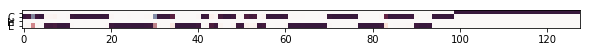

---
Input: EIDYKDIATLKNYITESGKIVPSRITGTRAKYQRQLARAIKRARYLSLLPYTDRH
Target: CCCCCCHHHHHCCECCCCCECCHHHHCCCHHHHHHHHHHHHHHHHCCCCCCCCCC
Result: CCCCCCHHHHHHHCCCCCCECCHHHCCCCHHHHHHHHHHHHHHHHCCCCCCCCCC


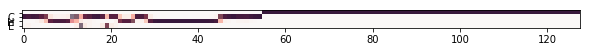

---
Input: MARLTAYERRKFRVRNRIKRTGRLRLSVFRSLKHIYAQIIDDEKGVTLVSASSLALKLKGNKTEVARQVGRALAEKALALGIKQVAFDRGPYKYHGRVKALAEGAREGGLEF
Target: CCCCCHHHHHHHHHHHHHHHCCCCEEEEEECCCCEEEEEEECCCCEEEEEEECCCCCCCCCHHHHHHHHHHHHHHHHHCCCCCECEEECCCCCCCHHHHHHHHHHHHHCCEC
Result: CCCCCHHHHHHHHHHHHHHCCCCCEEEEEECCCCEEEEEEECCCCEEEEEECCCCCCCCCCHHHHHHHHHHHHHHHHHHCCCCCCECCCCCCCCCCHHHHHHHHHHCCCCCC


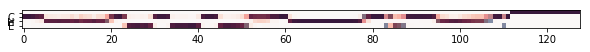

testing
---
Input: MIQPQTYLEVADNTGARKIMCIRVLKGSNAKYATVGDVIVASVKEAIPRGAVKEGDVVKAVVVRTKKEIKRPDGSAIRFDDNAAVIINNQLEPRGTRVFGPVARELREKGFMKIVSLAPEVL
Target: CECCCCEEEECECCCEEEEEEEEECCCCCCCCECCCCEEEEEEEEECCCCCCCCEEEEEEEEEECCCCEECCCCCEEEECCCEEEEECCCCCECCCCECCCECCHHHHHCCHHHHHHCCCEC
Result: CECCCCEEEECCCCCEEEEEEEEECCCCCCCCCCCCCEEEEEEEEECCCCCCCCCCEEEEEEEECCCCEECCCCCEEEECCCEEEEECCCCCECCCCCCCCECHHHHHHCCHHHHHHCCCEC


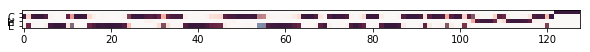

---
Input: GSHMGKNGQGEPARVRCSHLLVKHSQSRRPSSWRQEQITRTQEEALELINGYIQKIKSGEEDFESLASQFSDCSSAKARGDLGAFSRGQMQKPFEDASFALRTGEMSGPVFTDSGIHIILRTE
Target: CCCCCCCCCCCCCCEEEEEEEECCCCCCCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHCCCCHHHHHHHHCCCHHHHHCCEEEEECCCCCCHHHHHHHHHCCCCCECCCEEECCEEEEEEECC
Result: CCCCCCCCCCCCCCEEEEEEEECCCCCCCCCCCCCCCCCCCHHHHHHHHHHHHHHHHCCCCHHHHHHHHHCCHHHHHHCCHEEEEECCCCCHHHHHHHHHHCCCCCCCCEEECCCEEEEEEEC


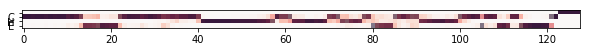

---
Input: MLIFVHIIAPVISGCAIAFFSYWLSRRNTK
Target: CHHHCCCCCCCHHHHHHHHHHHHHHHHCCC
Result: CEEEEEEECHHHHHHHHHHHHHCECCCCCC


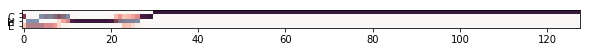

In [ ]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])

In [ ]:
t = model.predict(X_test)
res = np.zeros((3,3))
tres = np.zeros((3,3))
def diff(a, b):
  res = np.zeros((3,3))
  x = str(onehot_to_seq(a, revsere_decoder_index).upper())
  y = str(onehot_to_seq(b, revsere_decoder_index).upper())
  for i in range(len(x)):
    if (x[i]==y[i] and x[i]=='C'):
      res[0][0]+=1
    if (x[i]!=y[i] and x[i]=='C' and y[i]=='E'):
      res[1][0]+=1
    if (x[i]!=y[i] and x[i]=='C' and y[i]=='H'):
      res[2][0]+=1
    if(x[i]==y[i] and x[i]=='E'):
      res[1][1]+=1
    if (x[i]!=y[i] and x[i]=='E'and y[i]=='C'):
      res[0][1]+=1
    if (x[i]!=y[i] and x[i]=='E'and y[i]=='H'):
      res[2][1]+=1
    if(x[i]==y[i] and x[i]=='H'):
      res[2][2]+=1
    if(x[i]!=y[i] and x[i]=='H'and y[i]=='C'):
      res[0][2]+=1
    if(x[i]!=y[i] and x[i]=='H'and y[i]=='E'):
      res[1][2]+=1
  return res

for i in range(38357):
  tres=diff(t[i], y_test[i])
  res +=tres

[[0.83755082 0.05520088 0.10724829]
 [0.14351842 0.82095816 0.03552342]
 [0.07132036 0.00909858 0.91958106]]


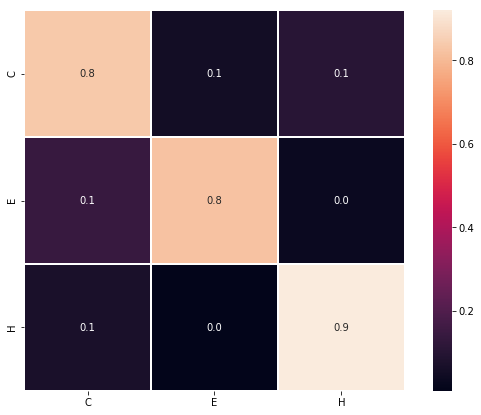

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf = np.zeros((3,3))
for i in range(3):
  for j in range(3):
    conf[i][j] = res[i][j]/(res[i].sum())
print(conf)

df_cm = pd.DataFrame(conf, index = [i for i in "CEH"],
                  columns = [i for i in "CEH"])
plt.figure(figsize = (10,7))
ax = sn.heatmap(df_cm, annot=True, fmt = '.1f', square=1, linewidth=1.)

In [ ]:
a = pd.DataFrame.from_dict(hist.history)
a.to_csv(r"GRUHistoryQ3.csv" , index = None, header=True)
a.head()
print (hist.history)

{'val_loss': [0.5576752357731293, 0.49475952658283545, 0.4670487560022392, 0.4385306048350361, 0.41902992523406163], 'val_acc': [0.8097093994840546, 0.8342655024087929, 0.8446757192050036, 0.8542809981895406, 0.8615370483705124], 'val_q3_acc': [0.6975428495018743, 0.7365377918008154, 0.7530854674021743, 0.7683520264476619, 0.7798795423828548], 'loss': [0.7030539339105963, 0.5243452248922805, 0.4723612014627077, 0.43934709102948244, 0.4143584388815441], 'acc': [0.7561189362004663, 0.8221341130772195, 0.841043855618746, 0.8525199501847692, 0.8609828807810621], 'q3_acc': [0.6136797157360631, 0.7171817725831153, 0.7472311778838822, 0.7654451370512759, 0.7789063382709006]}


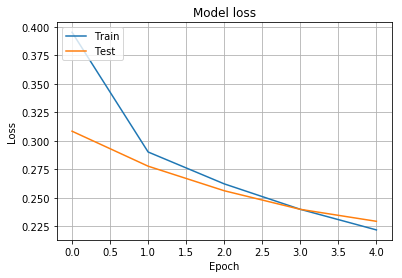

In [ ]:
f = plt.figure()
plt.grid()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
f.savefig("GRUModelLossQ3.pdf", bbox_inches='tight')

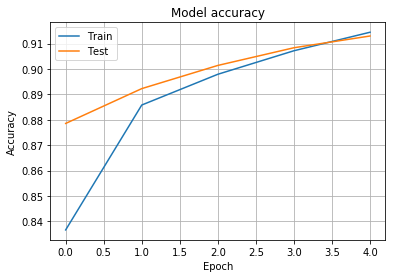

In [ ]:
f = plt.figure()
plt.grid()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
f.savefig("GRUModelAccuracyQ3.pdf", bbox_inches='tight')

In [ ]:
#train different sizes 

from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras import backend  as K
import tensorflow as tf
import keras
from keras.callbacks import History
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional,GRU

l=[25,50,100,150,200,250]

for i in l:
  X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.4, random_state=0)
  seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.4, random_state=0)


  n_words = len(tokenizer_encoder.word_index) + 1
  n_tags = len(tokenizer_decoder.word_index) + 1
  print(n_words, n_tags)

  input = Input(shape=(maxlen_seq,))
  x = Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq)(input)
  x = Bidirectional(GRU(units=i, return_sequences=True, recurrent_dropout=0.1))(x)
  y = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
  model = Model(input, y)
  model.summary()

  loss = []
  acc = []
  val_loss = []
  val_acc = []

  def q3_acc(y_true, y_pred):
      y = tf.argmax(y_true, axis=-1)
      y_ = tf.argmax(y_pred, axis=-1)
      mask = tf.greater(y, 0)
      return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())



  model.compile(optimizer="rmsprop", loss="categorical_crossentropy",  metrics=["accuracy", q3_acc])

  hist = History()

  history = model.fit(X_train, y_train, batch_size=128, epochs=5,steps_per_epoch=None, validation_steps=None, validation_data=(X_test, y_test), verbose=1, callbacks=[hist])


train for Q8

In [ ]:
input_seqs, target_seqs = df[['seq', 'sst8']][(df.len <= maxlen_seq) & (~df.has_nonstd_aa)].values.T
input_grams = seq2ngrams(input_seqs)
print(len(input_seqs))

95891


In [ ]:
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

tokenizer_encoder = Tokenizer()
tokenizer_encoder.fit_on_texts(input_grams)
input_data = tokenizer_encoder.texts_to_sequences(input_grams)
input_data = sequence.pad_sequences(input_data, maxlen=maxlen_seq, padding='post')

tokenizer_decoder = Tokenizer(char_level=True)
tokenizer_decoder.fit_on_texts(target_seqs)
target_data = tokenizer_decoder.texts_to_sequences(target_seqs)
target_data = sequence.pad_sequences(target_data, maxlen=maxlen_seq, padding='post')
target_data = to_categorical(target_data)
input_data.shape, target_data.shape

((95891, 128), (95891, 128, 9))

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional,GRU

n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1
print(n_words, n_tags)

input = Input(shape=(maxlen_seq,))
x = Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq)(input)
x = Bidirectional(GRU(units=64, return_sequences=True, recurrent_dropout=0.1))(x)
y = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
model = Model(input, y)
model.summary()

8421 9
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 128, 128)          1077888   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128, 128)          74112     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 128, 9)            1161      
Total params: 1,153,161
Trainable params: 1,153,161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras import backend  as K
import tensorflow as tf
import keras
from keras.callbacks import History

loss = []
acc = []
val_loss = []
val_acc = []

def q8_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def on_batch_end(self, batch, logs={}):
      loss.append(logs.get('loss'))
      acc.append(logs.get('acc'))
      val_acc.append(logs.get('val_acc'))
      val_loss.append(logs.get('val_loss'))
      return
    '''def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(model.predict(X_val))

        y_val = np.argmax(y_val, axis=1)
        y_predict = np.argmax(y_predict, axis=1)

        self._data.append({
            'val_recall': recall_score(y_val, y_predict),
            'val_precision': precision_score(y_val, y_predict),
        })
        return'''

model.compile(optimizer="rmsprop", loss="categorical_crossentropy",  metrics=["accuracy", q8_acc])

hist = History()
X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.4, random_state=0)
seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.4, random_state=0)

history = model.fit(X_train, y_train, batch_size=128, epochs=5,steps_per_epoch=None, validation_steps=None, validation_data=(X_test, y_test), verbose=1, callbacks=[hist])


Train on 57534 samples, validate on 38357 samples
Epoch 1/5
57534/57534 [==============================] - 265s 5ms/step - loss: 0.7025 - acc: 0.7561 - q8_acc: 0.6135 - val_loss: 0.5530 - val_acc: 0.8114 - val_q8_acc: 0.7002
Epoch 2/5
57534/57534 [==============================] - 264s 5ms/step - loss: 0.5219 - acc: 0.8230 - q8_acc: 0.7185 - val_loss: 0.5002 - val_acc: 0.8304 - val_q8_acc: 0.7304
Epoch 3/5
57534/57534 [==============================] - 263s 5ms/step - loss: 0.4735 - acc: 0.8407 - q8_acc: 0.7466 - val_loss: 0.4656 - val_acc: 0.8448 - val_q8_acc: 0.7533
Epoch 4/5
57534/57534 [==============================] - 263s 5ms/step - loss: 0.4411 - acc: 0.8520 - q8_acc: 0.7646 - val_loss: 0.4387 - val_acc: 0.8546 - val_q8_acc: 0.7689
Epoch 5/5
57534/57534 [==============================] - 263s 5ms/step - loss: 0.4152 - acc: 0.8606 - q8_acc: 0.7783 - val_loss: 0.4198 - val_acc: 0.8612 - val_q8_acc: 0.7794


training
---
Input: IQKTPQIQVYSRHPPENGKPNILNCYVTQFHPPHIEIQMLKNGKKIPKVEMSDMSFSKDWSFYILAHTEFTPTETDTYACRVKHASMAEPKTVYWDRDM
Target: CCCCCEEEEEESSCCCSSSCEEEEEEEEEESSSCCEEEEEETTEECSSCEECCCEECTTSCEEEEEEEEECCCSSCCEEEEEECSSCSSCEEEECCSCC
Result: CCBCCEEEEEESSCCCTTSCEEEEEEEEEEBSSCCEEEEEETTEECSCCEECCCEECTTSCEEEEEEEEECCCSSCCEEEEEECTTCSSCEEEECCTTC


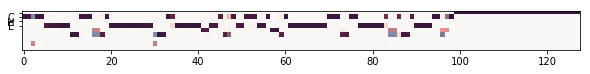

---
Input: EIDYKDIATLKNYITESGKIVPSRITGTRAKYQRQLARAIKRARYLSLLPYTDRH
Target: CCCSSCHHHHHTTBCTTSCBCCHHHHCCCHHHHHHHHHHHHHHHHTTSSCSCSCC
Result: CCCSSCHHHHHGGBCTTSCCCCHHHHCCHHHHHHHHHHHHHHHHHTTSSCSSSCC


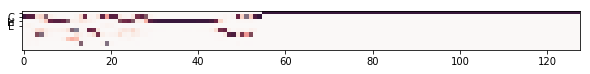

---
Input: MARLTAYERRKFRVRNRIKRTGRLRLSVFRSLKHIYAQIIDDEKGVTLVSASSLALKLKGNKTEVARQVGRALAEKALALGIKQVAFDRGPYKYHGRVKALAEGAREGGLEF
Target: CCCCCHHHHHHHHHHHHHHHTTCCEEEEEECSSCEEEEEEETTTTEEEEEEETTTTTCCSCHHHHHHHHHHHHHHHHHTTTCCBCEEECTTSCSCHHHHHHHHHHHHHTCBC
Result: CCCCCHHHHHHHHHHHHHHHTSCCEEEEEECSSCEEEEEEETTTTEEEEEEESTTTTCCSCHHHHHHHHHHHHHHHHHHTTCCCCEECCTTSCSSSHHHHHHHHHHCCCCCC


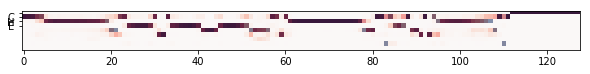

testing
---
Input: MIQPQTYLEVADNTGARKIMCIRVLKGSNAKYATVGDVIVASVKEAIPRGAVKEGDVVKAVVVRTKKEIKRPDGSAIRFDDNAAVIINNQLEPRGTRVFGPVARELREKGFMKIVSLAPEVL
Target: CBCTTCEEEECBSSSEEEEEEEEECSSSSCCCBCTTCEEEEEEEEECTTCSSCSEEEEEEEEEECSSCEECTTSCEEEESSCEEEEECTTCCBSSSCBCSCBCTHHHHHTCHHHHHHCSCBC
Result: CBCTTCEEEECBSSSEEEEEEEEECSSSSCCCBCTTCEEEEEEEEECTTSSSCTTCEEEEEEEECSSCEECTTSCEEEESSCEEEEECTTSCBSSSCBCSCBCHHHHHTTCHHHHHHSSCCC


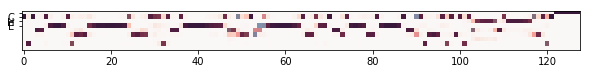

---
Input: GSHMGKNGQGEPARVRCSHLLVKHSQSRRPSSWRQEQITRTQEEALELINGYIQKIKSGEEDFESLASQFSDCSSAKARGDLGAFSRGQMQKPFEDASFALRTGEMSGPVFTDSGIHIILRTE
Target: CCCCCCCCCCCCSCEEEEEEEECCTTSSSCCCSSCSSCCCCHHHHHHHHHHHHHHHHHTSSCHHHHHHHHCSSGGGGGTTEEEEECTTSSCHHHHHHHHHSCTTCBCCCEEETTEEEEEEECC
Result: CCCCCCCCCCCCCEEEECEEEECCCSSBCCCCSCCSSCCCCHHHHHHHHHHHHHHHHTCCHHHHHHHHHHGGGGGGGGGTEEEEEETTEESSHHHHHHHHHTTSCCCCCEEECTTEEEEEEEC


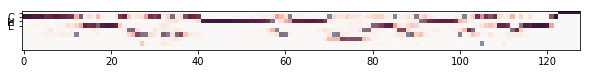

---
Input: MLIFVHIIAPVISGCAIAFFSYWLSRRNTK
Target: CGGGTSSTTTTHHHHHHHHHHHHHHHHSCC
Result: CEEEEEEEEEHHHHHHHHHHHHHECCCTCC


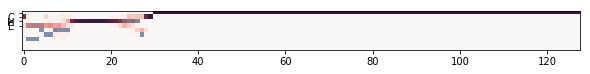

In [ ]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])

In [ ]:
a = pd.DataFrame.from_dict(hist.history)
a.to_csv(r"GRUHistoryQ8.csv" , index = None, header=True)
a.head()
print (hist.history)

{'val_loss': [0.5564335832463554, 0.5005146356409607, 0.4670435773116423, 0.4420743040938812, 0.4229878812688799], 'val_acc': [0.8107186270309606, 0.8322409371714723, 0.8442838415676378, 0.8533968293937537, 0.8601599773805091], 'val_q8_acc': [0.699142610723434, 0.7333188465058215, 0.7524462893586197, 0.7669401415123427, 0.7776876631533202], 'loss': [0.700179216218748, 0.525589875320318, 0.4773575665327772, 0.4443494094747504, 0.41892233308091686], 'acc': [0.7588201921989925, 0.8216873663584922, 0.839361426500184, 0.8509465598498966, 0.8596989932309542], 'q8_acc': [0.6177209606922203, 0.7163877987089199, 0.7444872046866241, 0.7629425079671617, 0.7768929367058468]}


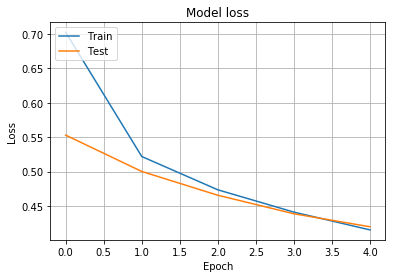

In [ ]:
f = plt.figure()
plt.grid()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
f.savefig("GRUModelLossQ8.pdf", bbox_inches='tight')

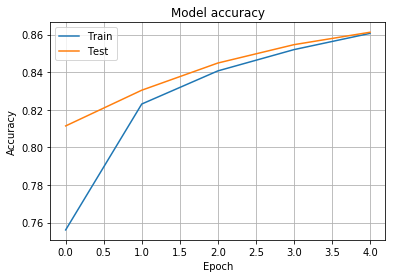

In [ ]:
f = plt.figure()
plt.grid()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
f.savefig("GRUModelAccuracyQ8.pdf", bbox_inches='tight')

In [ ]:
print (X_test.shape)
t = model.predict(X_test)

(38357, 128)


In [ ]:
#t = model.predict(X_test)
res = np.zeros((8,8))
tres = np.zeros((8,8))
def diff(a, b):
  res = np.zeros((8,8))
  x = str(onehot_to_seq(a, revsere_decoder_index).upper())
  y = str(onehot_to_seq(b, revsere_decoder_index).upper())
  for i in range(len(x)):
    if (x[i]==y[i] and x[i]=='B'):
      res[0][0]+=1
    if(x[i]=='B' and y[i]=='C'):
      res[0][1]+=1
    if(x[i]=='B' and y[i]=='E'):
      res[0][2]+=1
    if(x[i]=='B' and y[i]=='G'):
      res[0][3]+=1
    if(x[i]=='B' and y[i]=='H'):
      res[0][4]+=1
    if(x[i]=='B' and y[i]=='I'):
      res[0][5]+=1
    if(x[i]=='B' and y[i]=='S'):
      res[0][6]+=1
    if(x[i]=='B' and y[i]=='T'):
      res[0][7]+=1
    
    if (x[i]==y[i] and x[i]=='C'):
      res[1][1]+=1
    if(x[i]=='C' and y[i]=='B'):
      res[1][0]+=1
    if(x[i]=='C' and y[i]=='E'):
      res[1][2]+=1
    if(x[i]=='C' and y[i]=='G'):
      res[1][3]+=1
    if(x[i]=='C' and y[i]=='H'):
      res[1][4]+=1
    if(x[i]=='C' and y[i]=='I'):
      res[1][5]+=1
    if(x[i]=='C' and y[i]=='S'):
      res[1][6]+=1
    if(x[i]=='C' and y[i]=='T'):
      res[1][7]+=1
    
    if (x[i]==y[i] and x[i]=='E'):
      res[2][2]+=1
    if(x[i]=='E' and y[i]=='B'):
      res[2][0]+=1
    if(x[i]=='E' and y[i]=='C'):
      res[2][1]+=1
    if(x[i]=='E' and y[i]=='G'):
      res[2][3]+=1
    if(x[i]=='E' and y[i]=='H'):
      res[2][4]+=1
    if(x[i]=='E' and y[i]=='I'):
      res[2][5]+=1
    if(x[i]=='E' and y[i]=='S'):
      res[2][6]+=1
    if(x[i]=='E' and y[i]=='T'):
      res[2][7]+=1
      
    if (x[i]==y[i] and x[i]=='G'):
      res[3][3]+=1
    if(x[i]=='G' and y[i]=='B'):
      res[3][0]+=1
    if(x[i]=='G' and y[i]=='C'):
      res[3][1]+=1
    if(x[i]=='G' and y[i]=='E'):
      res[3][2]+=1
    if(x[i]=='G' and y[i]=='H'):
      res[3][4]+=1
    if(x[i]=='G' and y[i]=='I'):
      res[3][5]+=1
    if(x[i]=='G' and y[i]=='S'):
      res[3][6]+=1
    if(x[i]=='G' and y[i]=='T'):
      res[3][7]+=1
     
    if (x[i]==y[i] and x[i]=='H'):
      res[4][4]+=1
    if(x[i]=='H' and y[i]=='B'):
      res[4][0]+=1
    if(x[i]=='H' and y[i]=='C'):
      res[4][1]+=1
    if(x[i]=='H' and y[i]=='E'):
      res[4][2]+=1
    if(x[i]=='H' and y[i]=='G'):
      res[4][3]+=1
    if(x[i]=='H' and y[i]=='I'):
      res[4][5]+=1
    if(x[i]=='H' and y[i]=='S'):
      res[4][6]+=1
    if(x[i]=='H' and y[i]=='T'):
      res[4][7]+=1
     
    if (x[i]==y[i] and x[i]=='I'):
      res[5][5]+=1
    if(x[i]=='I' and y[i]=='B'):
      res[5][0]+=1
    if(x[i]=='I' and y[i]=='C'):
      res[5][1]+=1
    if(x[i]=='I' and y[i]=='E'):
      res[5][2]+=1
    if(x[i]=='I' and y[i]=='G'):
      res[5][3]+=1
    if(x[i]=='I' and y[i]=='H'):
      res[5][4]+=1
    if(x[i]=='I' and y[i]=='S'):
      res[5][6]+=1
    if(x[i]=='I' and y[i]=='T'):
      res[5][7]+=1
      
    if (x[i]==y[i] and x[i]=='S'):
      res[6][6]+=1
    if(x[i]=='S' and y[i]=='B'):
      res[6][0]+=1
    if(x[i]=='S' and y[i]=='C'):
      res[6][1]+=1
    if(x[i]=='S' and y[i]=='E'):
      res[6][2]+=1
    if(x[i]=='S' and y[i]=='G'):
      res[6][3]+=1
    if(x[i]=='S' and y[i]=='H'):
      res[6][4]+=1
    if(x[i]=='S' and y[i]=='I'):
      res[6][5]+=1
    if(x[i]=='S' and y[i]=='T'):
      res[6][7]+=1
      
    if (x[i]==y[i] and x[i]=='T'):
      res[7][7]+=1
    if(x[i]=='T' and y[i]=='B'):
      res[7][0]+=1
    if(x[i]=='T' and y[i]=='C'):
      res[7][1]+=1
    if(x[i]=='T' and y[i]=='E'):
      res[7][2]+=1
    if(x[i]=='T' and y[i]=='G'):
      res[7][3]+=1
    if(x[i]=='T' and y[i]=='H'):
      res[7][4]+=1
    if(x[i]=='T' and y[i]=='I'):
      res[7][5]+=1
    if(x[i]=='T' and y[i]=='S'):
      res[7][6]+=1
    
  return res

for i in range(38357):
  tres=diff(t[i], y_test[i])
  res +=tres

[[8.16300e+03 1.35000e+03 5.29000e+02 4.90000e+01 5.00000e+01 0.00000e+00
  4.98000e+02 1.80000e+02]
 [1.15210e+04 6.85630e+05 5.49410e+04 1.04740e+04 3.18660e+04 5.90000e+01
  6.87400e+04 4.00730e+04]
 [8.01800e+03 7.95090e+04 5.77326e+05 3.35200e+03 1.02470e+04 2.10000e+01
  1.81240e+04 1.15440e+04]
 [1.46000e+02 3.46500e+03 8.27000e+02 3.86930e+04 2.84300e+03 2.60000e+01
  3.18500e+03 7.66600e+03]
 [1.68300e+03 5.62830e+04 1.74620e+04 1.30790e+04 8.01524e+05 1.70000e+02
  2.35260e+04 5.33320e+04]
 [0.00000e+00 4.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.96000e+02
  1.00000e+00 2.40000e+01]
 [1.40100e+03 2.69110e+04 6.42100e+03 2.61800e+03 3.68300e+03 1.80000e+01
  1.19827e+05 1.89660e+04]
 [1.05600e+03 2.44570e+04 6.77900e+03 8.82300e+03 1.40070e+04 1.07000e+02
  3.12640e+04 1.76541e+05]]


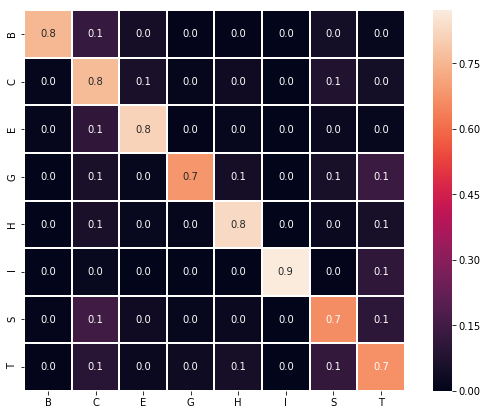

In [ ]:

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf = np.zeros((8,8))
for i in range(8):
  for j in range(8):
    conf[i][j] = res[i][j]/(res[i].sum())

print(res)
df_cm = pd.DataFrame(conf, index = [i for i in "BCEGHIST"],
                  columns = [i for i in "BCEGHIST"])
plt.figure(figsize = (10,7))
ax = sn.heatmap(df_cm, annot=True, fmt = '.1f', square=1, linewidth=1.)

In [ ]:
#differnet size of gru on Q8

from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras import backend  as K
import tensorflow as tf
import keras
from keras.callbacks import History
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional,GRU

l=[25,50,100,150,200,250]

for i in l:
  X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.4, random_state=0)
  seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.4, random_state=0)


  n_words = len(tokenizer_encoder.word_index) + 1
  n_tags = len(tokenizer_decoder.word_index) + 1
  print(n_words, n_tags)

  input = Input(shape=(maxlen_seq,))
  x = Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq)(input)
  x = Bidirectional(GRU(units=i, return_sequences=True, recurrent_dropout=0.1))(x)
  y = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
  model = Model(input, y)
  model.summary()

  loss = []
  acc = []
  val_loss = []
  val_acc = []

  def q8_acc(y_true, y_pred):
      y = tf.argmax(y_true, axis=-1)
      y_ = tf.argmax(y_pred, axis=-1)
      mask = tf.greater(y, 0)
      return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())



  model.compile(optimizer="rmsprop", loss="categorical_crossentropy",  metrics=["accuracy", q8_acc])

  hist = History()

  history = model.fit(X_train, y_train, batch_size=128, epochs=5,steps_per_epoch=None, validation_steps=None, validation_data=(X_test, y_test), verbose=1, callbacks=[hist])


8421 9
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 128)               0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 128, 128)          1077888   
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 128, 50)           23100     
_________________________________________________________________
time_distributed_14 (TimeDis (None, 128, 9)            459       
Total params: 1,101,447
Trainable params: 1,101,447
Non-trainable params: 0
_________________________________________________________________
Train on 57534 samples, validate on 38357 samples
Epoch 1/5
57534/57534 [==============================] - 193s 3ms/step - loss: 0.7560 - acc: 0.7471 - q8_acc: 0.5993 - val_loss: 0.5901 - val_acc: 0.7973 - val_q8_acc: 0.6779
Epoch 2/5
57534/57534 [=========